## Utilisation du jeu de données Xview2, qui intitialement présebnte des exemples de territoire avant et après dommage

Je m'écarte ici un peu de l'idée initiale qui était de produire un dataset à l'aide du RIl et de la BDTOPO et je me concentre + sur les datasets labellisés préexistants. J'entraine un modèle de segmentation de suus ou un modèle de déttection d'objet et je vois comment ça réagit sur donnée spleiades. 
Dans tousd les cas le travail sur le RIL et la BD TOPO est à conserver puisque ces derniers servent de vzlidation !

In [2]:
!pip install matplotlib
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install -q -q -q tqdm # progresbar


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 18.6 MB/s eta 0:00:00a 0:00:01
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [1]:
from zipfile import ZipFile
import s3fs
import tarfile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import DataLoader,  random_split
from torch.utils.data.dataset import Dataset
import torch.nn as nn
from tqdm import tqdm
import rasterio
import rasterio.plot as rp


#fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key =)


In [7]:
# je travaille sur une version minimale du dataset xview, le vrai fait 50 giga.. mais ça devrait déjà faire l'affaire pour travailler
fs.get('projet-slums-detection/Donnees/data_xBD.tar', 'data_xBD.tar')

In [ ]:
tar = tarfile.open("data_xBD.tar", "r:gz")
tar.extractall()
tar.close()

### chargement/observation en place des données

In [2]:
liste_image  = sorted(os.listdir("train/images/"))
liste_label  = sorted(os.listdir("train/labels/")) # boundingbox et polygones !!
liste_target  = sorted(os.listdir("train/targets/")) # le masque de segmentation !!

In [3]:
np.unique([nom_image.split("_")[0] for nom_image in liste_image])


array(['guatemala-volcano', 'hurricane-florence', 'hurricane-harvey',
       'hurricane-matthew', 'hurricane-michael', 'mexico-earthquake',
       'midwest-flooding', 'palu-tsunami', 'santa-rosa-wildfire',
       'socal-fire'], dtype='<U19')

In [4]:
selec_pre_disaster = [nom_image.split("_")[2] == "pre" for nom_image in liste_image]
selec_tout_sauf_social_fire = [ not nom_image.split("_")[0] in ["social-fire","palu-tsunami"] for nom_image in liste_image]

selec_train = np.array(selec_pre_disaster) * selec_tout_sauf_social_fire
selec_val = np.array(selec_pre_disaster) * list(map(lambda x: not x, selec_tout_sauf_social_fire))


train_images_paths = ["train/images/" + elt for elt in np.array(liste_image)[selec_train]]
train_masks_paths = ["train/targets/" + elt for elt in np.array(liste_target)[selec_train]]

valid_images_paths = ["train/images/" + elt for elt in np.array(liste_image)[selec_val]]
valid_masks_paths = ["train/targets/" + elt for elt in np.array(liste_target)[selec_val]]


sum(selec_pre_disaster)
sum(selec_train)
sum(selec_val)

113

## Observation du dataset

- Images de dimension 1024-1024 à découper en 4 * 250 pour avoir un diviseur de 2000 (pour les données pleiades) (donc en 4)
- Dans la classe data set splitter l'image en 4 et prendre un bout aléatoirement à chaque fois
- image à 3 channels, pas de RGB ici..
- est ce vraiment la mêlme résolution que pleiade ? résistance à la résolution ?

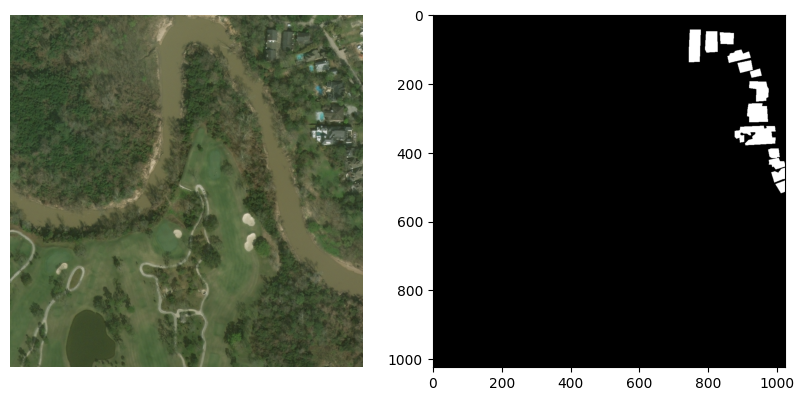

In [351]:
img = Image.open(train_images_paths[350]) # 30 ok
img = img.resize((1000,1000))

masque = Image.open(train_masks_paths[350])
masque = np.array(masque)
show_mask = np.zeros((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

# On traçe
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
ax1.imshow(img)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

A mettre dans la classe dataset ! sélection d'un pa(tch aléatoire parmi les 16  possibles

1 0


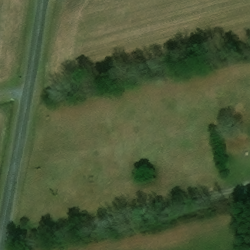

In [6]:
img = Image.open(train_images_paths[35])

img = img.crop((0,0,1000,1000))# je dégomme les derniers pixels..
img

facteur_div = 250
width, height = img.size

num_subparts_x = width//facteur_div
num_subparts_y =  height//facteur_div

# sélection aléatoire d'une aprtie de l'image pour le dataset
i = np.random.randint(num_subparts_x)
j = np.random.randint(num_subparts_y)

print(i,j)

left = j * facteur_div
right = (j+1) * facteur_div
top = i * facteur_div
bottom =(i+1)*facteur_div

out = img.crop((left,top,right,bottom))
out

Polygones associés au bati

In [7]:
 class CustomDataset(Dataset):
    def __init__(self, image_paths,mask_paths, facteur_div = 250):   # initial logic happens like transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.facteur_div = 250
        
    def __getitem__(self, idx):
       
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        with Image.open(self.image_paths[idx]) as img :
            
            img_pour_mean = torch.tensor(np.array(img,dtype = float), dtype =torch.float).permute(2,0,1)
            mean, std = img_pour_mean.mean([1,2]), img_pour_mean.std([1,2]) # moyenne sur toutes l'image avant patch sinon on a des cas dégénérés
            
            width, height = img.size

            num_subparts_x = width//self.facteur_div
            num_subparts_y =  height//self.facteur_div
            # sélection aléatoire d'une aprtie de l'image pour le dataset
            i = np.random.randint(num_subparts_x)
            j = np.random.randint(num_subparts_y)

            left = j * self.facteur_div
            right = (j+1) * self.facteur_div
            top = i * self.facteur_div
            bottom =(i+1)*self.facteur_div

            img = img.crop((left,top,right,bottom))
            img = img.convert("RGB")
            img_pil = img
            
            
            
        with Image.open(self.mask_paths[idx]) as masque :
            masque = masque.crop((left,top,right,bottom))
            masque = np.array(masque)
         
        
        masque = torch.tensor(masque,dtype = torch.long)
        
        img = torch.tensor(np.array(img,dtype = float), dtype =torch.float).permute(2,0,1)
        
        #if any(std == 0):
         #   mean = [0,0,0] 
          #  std = [1,1,1]
            
        img = transforms.Normalize(mean, std)(img)
        ID = str(self.image_paths[idx])
     
        return {"image": img, "masque" : masque,"image_pillow": np.array(img_pil) , "id" : ID} 
        
    def __len__(self):  
        return len(self.mask_paths)

In [8]:
train_dataset = CustomDataset(train_images_paths,train_masks_paths)
valid_dataset = CustomDataset(valid_images_paths,valid_masks_paths)

In [9]:
config = {"batch_size" : 17,
          "freq monitoring" : 10}

In [10]:

#train_size = 2000
#val_size = len(all_dataset.mask_paths) - train_size
#dans la liste donner la taille du train et la taille deu test
#train_dataset, valid_dataset = random_split(all_dataset,[train_size,val_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], 
                          shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=3, shuffle=True, num_workers=0)

next(iter(valid_loader))["image"].shape # parfait

torch.Size([3, 3, 250, 250])

In [11]:
if torch.cuda.is_available() : device= torch.device("cuda:0" )
else : device = "cpu"

print("Using {} device".format(device))
if torch.cuda.is_available() :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

    # Load the pretrained model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True) # 233 Mega
# 1 classe !
model.classifier[4] = nn.Conv2d(256,2,kernel_size = (1,1),stride =(1,1))

model = model.to(device)


Using cuda:0 device
nom du GPU : Tesla T4
GPU initialisé :  True


/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /home/onyxia/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [12]:

# Initialize the number of parameters
total_params = 0

# Loop through the parameters in the model
for param in model.parameters():
    # Get the size of the parameter tensor
    size = param.size()
    # Multiply the size of the tensor by the number of elements in it
    num_params = torch.prod(torch.tensor(size)).item()
    # Add the number of parameters to the total
    total_params += num_params

# Print the total number of parameters
print("Total number of parameters: ", total_params) # 60 millions..


Total number of parameters:  60991319


In [ ]:
# autre idée : pour un batch donné 
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Train the model
for epoch in range(100):
    
    running_loss = 0.0
    t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
    epoch_loop = enumerate(t)

    for i, data in epoch_loop:
        
        images = data["image"].to(device)
        labels = data["masque"].to(device)
        optimizer.zero_grad()
        output = model(images)["out"]
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        
        del images, labels, output
        running_loss += loss.item()
        
        if (i+1) % config['freq monitoring'] == 0:  
                t.set_description("epoch %i, 'mean loss: %.6f'" % (epoch+1,running_loss/config['freq monitoring']))
                t.refresh()
                running_loss =0


epoch 12, 'mean loss: 0.109268':  97%|█████████▋| 153/158 [09:03<00:17,  3.53s/it]

In [18]:
    
#Save the trained model
torch.save(model.state_dict(), 'model.pth')

Wandb

## Tests visuels du modele

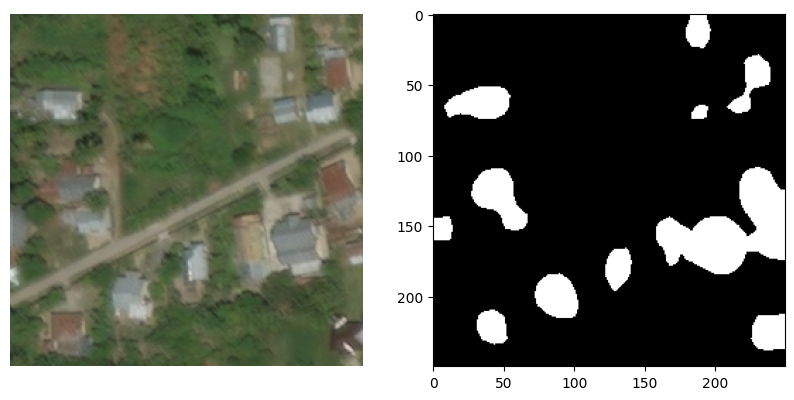

In [104]:
# 250*250 = 62500
indice_dans_batch = 0
data_val  = next(iter(valid_loader))
#data_val = next(iter(train_loader))
data_val["image"].shape
output = np.array(model(data_val["image"].to(device))["out"].to("cpu").detach())[indice_dans_batch]
output_predictions = output.argmax(0)
img_init = Image.fromarray(np.array(data_val["image_pillow"][indice_dans_batch]))

masque = output_predictions
show_mask = np.zeros((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

fig,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
ax1.imshow(img_init)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

Marche bien sur les images de validation !

## pleiade !!!!! test 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [51]:
import s3fs 
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key ='BG8A88QOYOCCC4H3WDD3', secret = 'CuwsRVZZ1zwI7hxh4SKe6eF2ynwjfZCrp4nLf4rx', token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJCRzhBODhRT1lPQ0NDNEgzV0REMyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc1OTY2ODAwLCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNsZW1lbnQuZ3VpbGxvQGluc2VlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3NjQ1OTEwMSwiZmFtaWx5X25hbWUiOiJHdWlsbG8iLCJnaXZlbl9uYW1lIjoiQ2zDqW1lbnQiLCJncm91cHMiOlsiY2hhbGxlbmdlZGF0YS1lbnMiLCJmdW5hdGhvbiIsInNsdW1zLWRldGVjdGlvbiJdLCJpYXQiOjE2NzU5NjY4MDEsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiIxNjZmNTlhNC0wNzcxLTQwYTMtYmQzOS0yZWY3NDIwNjZjOTMiLCJsb2NhbGUiOiJlbiIsIm5hbWUiOiJDbMOpbWVudCBHdWlsbG8iLCJub25jZSI6IjNiY2RhYjFjLTg1ZTAtNGM3Yi05ZjQ5LTIyN2JlNjUyZDU4OCIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjZ3VpbGxvIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNlc3Npb25fc3RhdGUiOiJkNzUyNTg3Mi0wMWYxLTRiODUtYmYxMy0zOGYzMTRmZGIxZGEiLCJzaWQiOiJkNzUyNTg3Mi0wMWYxLTRiODUtYmYxMy0zOGYzMTRmZGIxZGEiLCJzdWIiOiIzYjA2ZWZhNC01OWZlLTQzYzgtYTAyYi1hOTRkOWI0YjU0NGUiLCJ0eXAiOiJCZWFyZXIifQ.75iqRq2DnaaXXvGfpHVfZi0ulrNZsp7xdi-QZr2TFg4qY0WjlI3CzpyvCBdUnNtSEB5pCtFtMAwzCkdYpZLtPQ')
fs.get('projet-slums-detection/Donnees/PLEIADES/Cayenne_200722', 'Cayenne_200722')

# DL du contenu d'un dossier avec récursive
fs.download(
        rpath="projet-slums-detection/Donnees/PLEIADES/Cayenne_200722",
        lpath="../notebooks/Cayenne_200722",
        recursive=True)

In [46]:
!pip install rasterio  -q -q -q # marche indépendemment des instalaltions précédentes !!

Pour ne pas galérer à savoir l'image que je veux représenter je vais toutes les ouvrir en bouclant et je les représente, je les ouvre avac un oviews =16 pour diminuer la taille

In [ ]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = np.array([im_dir+l for l in liste])

Y = np.array([path_image.split("_")[6] for path_image in list_path_image])
order_y = np.argsort(np.array(Y))
Y = Y[order_y]
list_path_image = list_path_image[order_y]

X = [path_image.split("_")[5] for path_image in list_path_image]
list_path_image = list_path_image[np.lexsort((Y,X))]
list_path_image[1:10]

In [335]:
list_path_image.reshape(15,-1)[0]

array(['Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0534_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0535_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0536_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0537_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0538_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0539_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0540_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0541_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0348_0542_U22N_16Bits.jp2',
       'Cayenne_200722/16bits/ORT_2022072050325085_U22N

In [336]:
num_cols = 16
num_rows = 15

mat_list_path_image = list_path_image.reshape(15,-1)
images = np.empty((num_rows,num_cols), dtype = object)

for i in range(num_rows):
    for j in range(num_cols):
        filepath = mat_list_path_image[i,j]
        with rasterio.open(filepath) as raster:
            oviews = raster.overviews(1) # list of overviews from biggest to smallest
            oview = 16 # let's look at the smallest thumbnail

            # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
            B1 = raster.read(1, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
            B2 = raster.read(2, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
            B3 = raster.read(3, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
            B4 = raster.read(4, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))

        quantile = 0.97
        B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,quantile))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
        B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,quantile)))
        B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,quantile)))
        B4a = rp.adjust_band(np.clip(B4,0,np.quantile(B4,quantile)))

        rgb = np.dstack((B1a,B2a,B3a))
        rgbvegetal = np.dstack((B4a,B1a,B2a))

        images[i,j] = rgb
images =np.flip(np.transpose(images),axis=0)
mat_list_path_image =np.flip(np.transpose(mat_list_path_image),axis=0)

Et je représente tout ça dans une grille

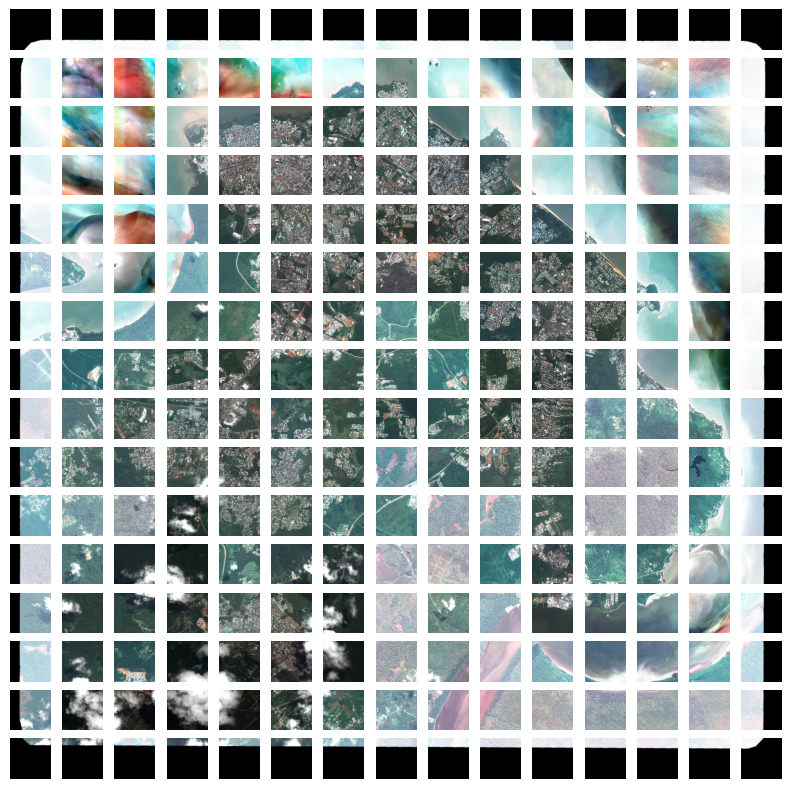

In [337]:

# Create a figure and axes
fig, axs = plt.subplots(nrows=num_cols, ncols=num_rows, figsize=(10, 10))

# Iterate over the images and plot them
for i in range(num_cols):
    for j in range(num_rows):
        axs[i,j].imshow(images[i,j])

# Remove any unused axes
for i in range(num_cols):
    for j in range(num_rows):
        axs[i,j].set_axis_off()

# Show the plot
plt.show()


In [381]:

filepath =  mat_list_path_image[9,5] 
filepath =  mat_list_path_image[7,11]
filepath =  mat_list_path_image[2,4] # cool
filepath =  mat_list_path_image[4,10] # bof bof
filepath =  mat_list_path_image[9,2] # bof
filepath =  mat_list_path_image[8,10] # bof
filepath =  mat_list_path_image[12,5] # Ok
filepath =  mat_list_path_image[12,4] # Ok
# interesting# il faut compter en colonnes
#filepath = 'Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'


Lecture Image (remplacer par fonction tom Thomas ?)

In [382]:
with rasterio.open(filepath) as raster:
    oviews = raster.overviews(1) # list of overviews from biggest to smallest
    oview = 1 # let's look at the smallest thumbnail

    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    B1 = raster.read(1, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B2 = raster.read(2, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B3 = raster.read(3, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))
    B4 = raster.read(4, out_shape=(1, int(raster.height // oview), int(raster.width // oview)))

quantile = 0.97
B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,quantile))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,quantile)))
B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,quantile)))
B4a = rp.adjust_band(np.clip(B4,0,np.quantile(B4,quantile)))

rgb = np.dstack((B1a,B2a,B3a))
rgbvegetal = np.dstack((B4a,B1a,B2a))

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(rgb)
#plt.title("Représentation de l'image {}".format(filepath))
#plt.xlabel('Pixels Colonnes')
#plt.ylabel('Pixels Lignes')
#plt.show()

im_pleiade = Image.fromarray(np.array(rgb * 255,dtype = np.uint8))
#rgb

Application du modèle sur un crop de taille 250 x 250

La Normalisation met tout en l'air lorsque on joue avec les données pleiades --'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


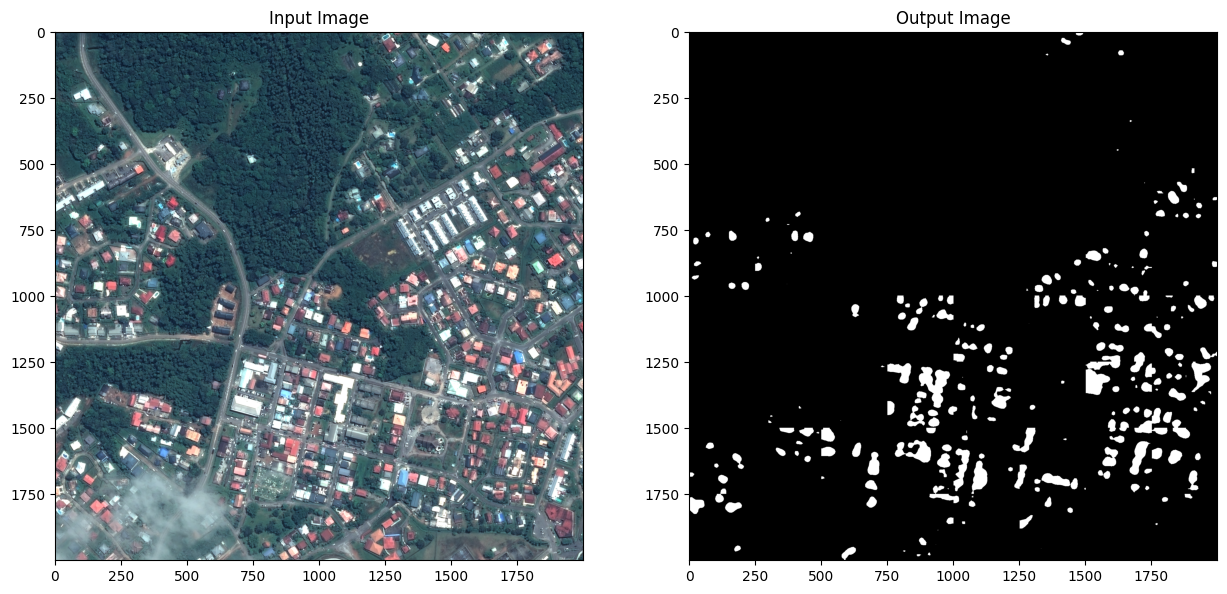

In [383]:
# def segment_image(input_image, model):
# Load input image
input_image = im_pleiade

# Define tile size and stride
tile_size = 250
stride = 250

# Get input image dimensions
width, height = input_image.size

# Create empty output image
output_image = np.zeros((height, width, 3))

# Slice input image into tiles, feed them into segmentation network, and combine results
for i in range(0, height - tile_size + 1, stride):
    for j in range(0, width - tile_size + 1, stride):
        # Extract tile from input image
        tile = input_image.crop((j, i, j + tile_size, i + tile_size))
        tile = torch.tensor(np.array(tile),dtype = torch.float).permute(2,0,1).to(device)
        
        # normalisation or not normalisation ? en théorie pui mais là c'est pas top
        #mean, std = tile.mean([1,2]), tile.std([1,2])
        #tile = transforms.Normalize(mean, std)(tile)
        #print(tile.shape)
        
        # Feed tile into segmentation network and get output
        with torch.no_grad():
            out = model(tile.unsqueeze(0))["out"]

        # Convert output to numpy array and append to output image
        output = np.array(out.to("cpu").detach()).squeeze(0)
        output_predictions = output.argmax(0)
        masque = output_predictions
        show_mask = np.zeros((*masque.shape, 3))
        show_mask[masque == 1, :] = [255,255,255]
        output = show_mask.astype(np.uint8)
        #output = np.transpose(output, (1, 2, 0))
        output_image[i:i+tile_size, j:j+tile_size, :] = output
        
#mean, std = torch_patch.mean([1,2]), torch_patch.std([1,2])
#torch_patch = transforms.Normalize(mean, std)(torch_patch).unsqueeze(0) #reshape(1,3,250,250)
# je rajoute moyenne etc..


# Display input image, tiles, and output image as a grid
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(input_image)
ax[0].set_title('Input Image')
ax[1].imshow(output_image)
ax[1].set_title('Output Image')
plt.show()


## Satistiques sur les couleurs des images
- au programme : observation de la distribution des pixels suyrcertaines ilages pleiades et images xView
- normalisation pour centrage réduction
- regarderr la distribution des ratios inter pixels , les valeurs extremes etc.. faire de la stat
- eventuellement sur plusieurs images

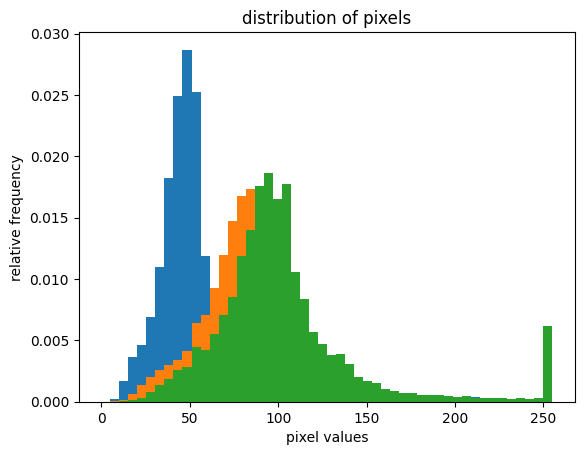

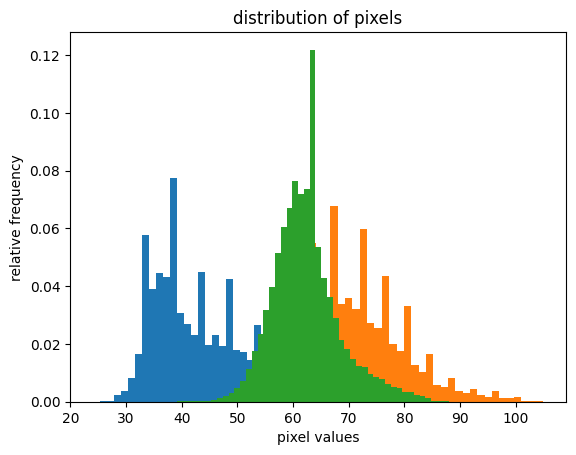

In [358]:
plt.hist(np.array(im_pleiade)[:,:,0].ravel(),bins = 50, density = True)
plt.hist(np.array(im_pleiade)[:,:,1].ravel(),bins = 50, density = True)
plt.hist(np.array(im_pleiade)[:,:,2].ravel(),bins = 50, density = True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

plt.show()
imxview =np.array(data_val["image_pillow"][2])
plt.hist(imxview[:,:,0].ravel(),bins = 50, density = True)
plt.hist(imxview[:,:,1].ravel(),bins = 50, density = True)
plt.hist(imxview[:,:,2].ravel(),bins = 50, density = True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

plt.show()

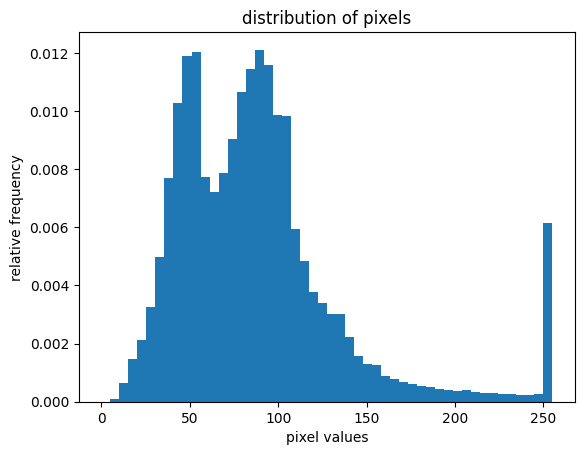

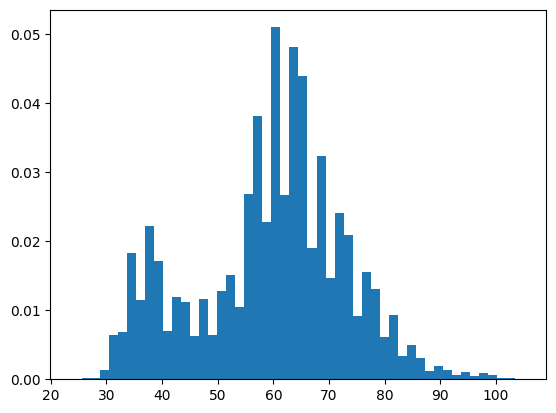

In [359]:


plt.hist(np.array(im_pleiade).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

plt.show()

plt.hist(np.array(imxview).ravel(), bins=50, density=True)

plt.show()

# TO DO

In [363]:
- MLFlow + ligthning torch
- Idée même si on ne détecte pas tout faire une polygonisation de nos pixels détectés et des buffers ou une approche graphe pour dessiner des zones de detection (ex 3 points =triangles)
(travail sur les masques produits finalement)
- il nous faudrait un cas exemple d'un teritoire sur 2 années différentes pour voir si ça marche
- apurement du jeu de données , trop de patch sans logements.. à enlever et c'est faisable (en filtrant au préalable sur les labels)
- petite présnetation / bilan d'étape
- dessiner au brouillon l'architecture du projet avec les entrainemenbt avec la volonté detre agnostique au type de modèle
- validation en utilisant les labels RIL !! (les utiliser aussi pour l'zentraînement)

- transferabilité résolution / couleurs pourquoi kla normaklisation kill the game ?
- faire un taf en 2 temps test buildoing dans la zone puis segmentation
- to do : utiliser les bounding box pour faire autre chose que de la segmentation
- faire un énorme schéma
- équilibrer jeu de donnée avec les 0 et 1. prendre que des exemple ou il y a des 1
- Rappatrier un peu de biblio suivant les différentes étapes
                                             

SyntaxError: unterminated string literal (detected at line 4) (3772638615.py, line 4)

In [385]:
- Présentation générale
- Algo avec BBOX
- augmenter le nooùmbre d'images d'entraînement xview dataset
- normalisation aps top sur Guyane, pb de transférabilité
- Semble détecter des logements facilement quand il y 'en a beaucoup autour (transférabilité des résolutions?)
- surcouche dans le modèle xview pour dégager lme ["out"] 
- mettre au propre les entraînements avec ligthning torch
- regarder torchgeo
- ml flow pour l'enregistrement des modèles
- INTEGRER TOUT CA DANS LE FRAMEWORK DES GARS

SyntaxError: unterminated string literal (detected at line 5) (1196422989.py, line 5)